In [1]:
!pip install scattertext
!pip install wordcloud

In [0]:
import requests
from pandas.io.json import json_normalize
import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt

In [0]:
def get_word_cloud(texts):
  text = ' '.join(texts)
  return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
  plt.figure(**figure_kwargs)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

  
def show_word_cloud_from_texts(text_column):
  texts = text_column.fillna('').values
  cloud = get_word_cloud(texts)
  show_word_cloud(cloud)

Upload your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [0]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

TODO: handle pagination

In [0]:
# An example to get the remaining rate limit using the Github GraphQL API.
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
query_string = """{
  viewer {
    starredRepositories(last: 100) {
      nodes {
        name
        owner {
          login
        }
        description
        primaryLanguage {
          name
        }
        repositoryTopics(first: 10) {
          nodes {
            topic {
              name
            }
          }
        }
      }
    }
  }
}"""

result = run_query(query_string)

In [0]:
starred_repo_information = result['data']['viewer']['starredRepositories']['nodes']

In [0]:
def get_cleaned_starred_repositories_df(starred_repo_information):
  starred_repo_df = json_normalize(starred_repo_information)
  starred_repo_df.index = starred_repo_df['name']
  starred_repo_df['primaryLanguage'] = starred_repo_df['primaryLanguage.name']
  starred_repo_df.drop('primaryLanguage.name', axis=1)
  starred_repo_df['topics'] = starred_repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
  return starred_repo_df

In [0]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

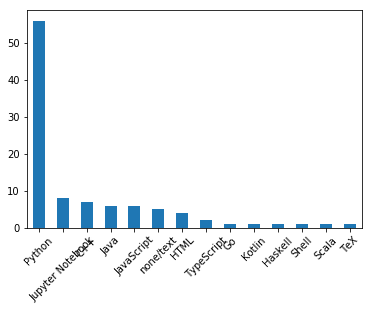

In [9]:
starred_repo_df['primaryLanguage'].fillna('none/text').value_counts().plot.bar(rot=45);

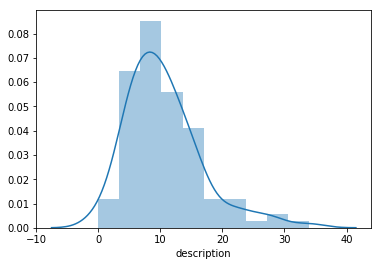

In [10]:
sns.distplot(starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

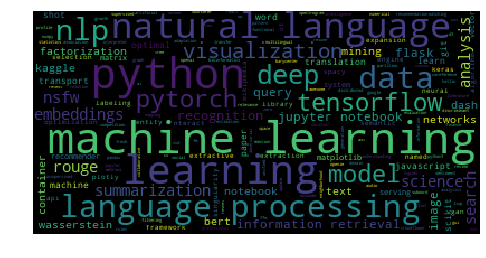

In [11]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

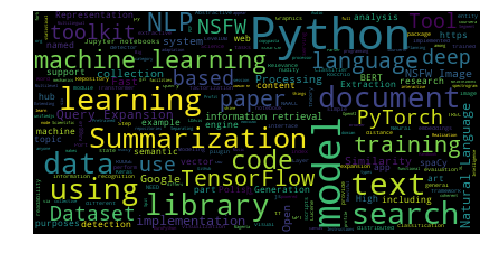

In [12]:
show_word_cloud_from_texts(starred_repo_df['description'])